In [1]:
from cpr.Nivel import Nivel
from cpr.SqlDb import SqlDb
import cpr.information as info
import os
import datetime
import pandas as pd

/usr/local/lib/python3.6/dist-packages/wmf/wmf.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mcano/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mcano/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mcano/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/mcano/.local/lib/python3.6/site-

In [2]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=30)
self = Nivel(codigo=99,**info.LOCAL)

In [4]:
level = self.level(start,end,calidad = True)

In [3]:
self.user = 'root'
self.passwd = 'mcanoYw2E#'
self.execute_sql('SET GLOBAL max_allowed_packet=1073741824;')

In [6]:
self.insert_myusers_hydrodata(start,end)

2018-09-27 15:47:insert_myusers_hydrodata:425.2 sec


In [5]:
def level_local_all(self,start,end):
    '''
    Gets last topo-batimetry in db
    Parameters
    ----------
    x_sensor   :   x location of sensor or point to adjust topo-batimetry
    Returns
    ----------
    last topo-batimetry in db, DataFrame
    '''
    start,end = (start.strftime('%Y-%m-%d %H:%M'),end.strftime('%Y-%m-%d %H:%M'))
    query = "select fk_id,fecha,profundidad from myusers_hydrodata where fecha between '%s' and '%s'"%(start,end)
    df = self.read_sql(query).set_index('fk_id').loc[self.infost.index].set_index('fecha',append=True)
    codigos = df.index.levels[0]
    nivel = df.reset_index('fecha').loc[codigos,'profundidad']
    df = df.reset_index('fecha')
    df = df.set_index('fecha',append=True)
    df[df<0.0] = np.NaN
    return df.unstack(0)['profundidad']

In [7]:
import numpy as np

In [8]:
df = level_local_all(self,start,end)

/home/mcano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


In [ ]:
def level_local_all(self,start,end):
    '''
    Gets last topo-batimetry in db
    Parameters
    ----------
    x_sensor   :   x location of sensor or point to adjust topo-batimetry
    Returns
    ----------
    last topo-batimetry in db, DataFrame
    '''
    start,end = (start.strftime('%Y-%m-%d %H:%M'),end.strftime('%Y-%m-%d %H:%M'))
    query = "select fk_id,fecha,profundidad from myusers_hydrodata where fecha between '%s' and '%s'"%(start,end)
    df = self.read_sql(query).set_index('fk_id').loc[self.infost.index].set_index('fecha',append=True)
    codigos = df.index.levels[0]
    nivel = df.reset_index('fecha').loc[codigos,'profundidad']
    df = df.reset_index('fecha')
    df = df.set_index('fecha',append=True)
    df[df<0.0] = np.NaN
    return df.unstack(0)['profundidad']

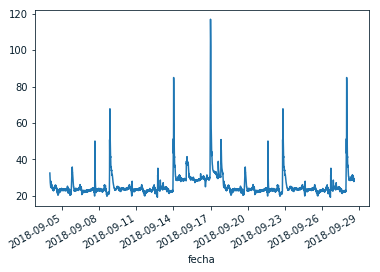

In [13]:
df[99].plot()

In [4]:
def duplicate_existing_table(self,table_name):
    '''
    inserts data into SQL table from list of fields and values
    Parameters
    ----------
    table_name   = SQL db table name
    Returns
    -------
    Sql sentence,str
    '''
    df = self.read_sql('describe %s'%table_name)
    df['Null'][df['Null']=='NO'] = 'NOT NULL'
    df['Null'][df['Null']=='YES'] = 'NULL'
    sentence = 'CREATE TABLE %s ('%table_name
    if df[df['Extra']=='auto_increment'].empty:
        pk = None
    else:
        pk = df[df['Extra']=='auto_increment']['Field'].values[0]
    for id,serie in df.iterrows():
        if (serie.Default=='0') or (serie.Default is None):
            row = '%s %s %s'%(serie.Field,serie.Type,serie.Null)
        else:
            if (serie.Default == 'CURRENT_TIMESTAMP'):
                serie.Default = "DEFAULT %s"%serie.Default
            elif serie.Default == '0000-00-00':
                serie.Default = "DEFAULT '1000-01-01 00:00:00'"
            else:
                serie.Default = "DEFAULT '%s'"%serie.Default
            row = '%s %s %s %s'%(serie.Field,serie.Type,serie.Null,serie.Default)
        if serie.Extra:
            row += ' %s,'%serie.Extra
        else:
            row += ',' 
        sentence+=row
    if pk:
        sentence +='PRIMARY KEY (%s)'%pk
    else:
        sentence = sentence[:-1]
    sentence +=');'
    return sentence

def siata_remote_data_to_transfer(start,end):
    remote = cpr.Nivel(**cpr.info.REMOTE)
    codigos_str = '('+str(list(self.infost.index)).strip('[]')+')'
    df = remote.read_sql('SELECT * FROM datos WHERE cliente in %s and %s'%(codigos_str,self.fecha_hora_query(start,end)))
    return df

def default_values(self,table_name):
    describe_table = self.read_sql('describe %s'%table_name)
    not_null = describe_table['Default'].notnull()
    default_values = describe_table[['Field','Default','Type']][not_null].set_index('Field')[['Default','Type']]
    return default_values

def filter_data_to_update(table_name,path):
    default = default_values(self,table_name)
    if default[default['Type']=='time'].empty:
        time_fields = None
    else:
        time_fields = default[default['Type']=='time']
    for index,s in time_fields.iterrows():
        df = pd.read_csv(path,index_col=0)
        df[index] = df[index].apply(lambda x:str(x)[6:15])
    return df.applymap(lambda x:str(x))

def insert_in_datos(path):
    inicia = datetime.datetime.now()
    table_name = 'datos'
    df = filter_data_to_update(table_name,path)
    query = 'INSERT INTO %s '%table_name+'('+str(list(df.columns)).strip('[]').replace("'",'')+') VALUES '
    for id,s in df.iterrows():
        query+=('('+str(list(s.values)).strip('[]'))+'), '
    query = query[:-2]+' ON DUPLICATE KEY UPDATE '
    describe = self.read_sql('describe %s;'%table_name)
    not_primary_keys = describe[describe['Key']!='PRI']
    if not_primary_keys.empty:
        not_primary_keys = describe.Field.values
    else:
        not_primary_keys = not_primary_keys.Field.values
    for key in not_primary_keys:
        query+=('%s = VALUES(%s), '%(key,key))
    query=query[:-2]
    finaliza = datetime.datetime.now()
    self.host = 'localhost'
    self.execute_sql('SET GLOBAL max_allowed_packet=1073741824;')
    self.execute_sql(query)
    print(finaliza - inicia)
    
#os.system("scp -r mcano@siata.gov.co:data_migration/* ../../cprweb/src/media/data_migration/")

self = SqlDb(**info.REMOTE)
folder_path = '/home/mcano/dev/cprweb/src/media/weekly_data/'
files = os.listdir(folder_path)
self.user = 'root'
self.host = 'localhost'

In [ ]:
local = SqlDb(**info.REMOTE) 
local.passwd = input('root password to configure max allowed packet:')
local.execute_sql("ALTER TABLE myusers_hydrodata ADD UNIQUE(fecha,fk_id);")

In [3]:
for path in files:
    insert_in_datos(folder_path+path)

0:00:26.155669
0:00:27.034194
0:00:27.375644
0:00:43.142851
0:00:28.667152
0:00:31.006532
0:00:48.761271
0:00:29.248145
0:00:28.208838
0:00:27.787453
0:00:27.288588
0:00:27.829492
0:00:28.027138
0:00:27.911746
0:00:33.909706
0:00:28.477437
0:00:28.043613
0:00:29.726179
0:00:27.768112
0:00:28.105281
0:00:28.807833
0:00:29.717089
0:00:28.383642
0:00:28.646270
0:00:28.181506
0:00:28.952114
0:00:29.278726
0:00:29.177116
0:00:28.987676
0:00:28.189464


In [11]:
self = SqlDb(**info.REMOTE)
files = os.listdir(folder_path)

april = []
for path in files:
    if path[:20] == 'weekly_level_2018-04':
        april.append(path)

date_offset = pd.to_datetime(level.dropna().index[-1])
date = date_offset-pd.to_datetime(pd.read_csv(folder_path + april[0],index_col=0)['fecha'][0])
for path in april:
    raw_data = pd.read_csv(folder_path + path,index_col=0)
    raw_data['fecha'] = (pd.to_datetime(raw_data['fecha']) + datetime.timedelta(days=date.days)).apply(lambda x:x.strftime('%Y-%m-%d'))
    raw_data.to_csv(folder_path+'future_'+path)
    insert_in_datos(folder_path+'future_'+path)

0:00:30.739298
0:00:27.814135
0:00:27.870210
0:00:26.896136
0:00:27.881269


### batimetrias

In [ ]:
self = Nivel(codigo=93,**info.LOCAL)
folderpath = self.data_path + "ultimos_levantamientos/"
for path in os.listdir(folderpath):
    try:
        #metadata
        codigo = int(path.replace('.csv',''))
        id = self.infost.loc[codigo,'id']
        fecha = datetime.datetime.now().strftime('%Y-%m-%d')
        hora = datetime.datetime.now().strftime('%H')
        minuto = datetime.datetime.now().strftime('%M')
        time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        #topo
        lev = pd.read_csv(folderpath+path,index_col=0)
        lev['y'] = lev['y'].apply(lambda x:round(x,3))
        lev = lev.reset_index()
        lev.columns = ['vertical','x','y']
        columns = '(fecha,hora,minuto,tipo_salida,timestamp,updated,user_id,item_fk_id)'
        queryst = "INSERT INTO myusers_item" + columns
        queryst += " VALUES('%s','%s','%s','siata-batimetria','%s','%s','1','%s');"%(fecha,hora,minuto,time,time,id)
        self.execute_sql(queryst)
        fk_id = self.read_sql("select id from myusers_item where fecha = '%s' and hora = '%s' and item_fk_id = '%s'"%(fecha,hora,id))
        if fk_id.empty:
            pass
        else:
            for i,s in lev.iterrows():
                vertical,x,y = (s.values)
                query = "INSERT INTO myusers_topo (vertical, x, y, timestamp, updated, fk_id, user_id) VALUES"
                query += (" ('%s','%s','%.3f','%s','%s','%s','1');")%(vertical,x,y,time,time,fk_id.loc[0,'id']) 
                self.execute_sql(query)
    except:
        print(path)

In [33]:
remote.duplicate_existing_table('datos')

"CREATE TABLE datos (id int(255) NOT NULL,fecha date NOT NULL DEFAULT '1000-01-01 00:00:00',hora time NOT NULL DEFAULT '00:00:00',cliente int(255) NOT NULL,P1 float NOT NULL DEFAULT '-999',P2 float NOT NULL DEFAULT '-999',PR float NOT NULL DEFAULT '-999',calidad int(10) NULL DEFAULT '1',NI float NULL DEFAULT '-999',source varchar(1) NULL);"